# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', 500)
import numpy as np
import ipywidgets as widgets

from sklearn.model_selection import train_test_split

from sklearn import ensemble #gradientboosting
from sklearn import linear_model #lasso
from sklearn import tree #decision tree

from sklearn.metrics import mean_absolute_error
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# below imports add mpld3 functionality
# hover-over labels for plots
#import mpld3
#mpld3.enable_notebook()

train_scores = dict() ; test_scores  = dict() #to hold scores for viewing at the end

In [2]:
def produce_exp_vs_pred_df(features_list, model, codename):
    pred_list = []
    for i in range(0, len(X)):
        prediction = model.predict([X[features_list].iloc[i]])
        pred_list.append(prediction)
    train_scores.update({codename : model.score(X_train, y_train)})
    test_scores.update({codename : model.score(X_test, y_test)})
    exp_vs_calc = pd.DataFrame(y)
    exp_vs_calc['Predicted'] = pred_list
    exp_vs_calc.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
    return exp_vs_calc

def prediction_plot_scores(model_func, pred_df):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    print('Training Score:\t', model_func.score(X_train, y_train))
    print('Testing Score:\t', model_func.score(X_test, y_test))
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    #abels = ['{}'.format(i) for i in species_names]
    #ooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    #pld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# DRAGON descriptors
## Bringing in data and splitting it into parts

In [3]:
csv = pd.read_csv('filtered_organics_desc_kh.csv') # contains VP/AS HLCs

print(csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print(csv.shape) #removed NaN shape

species_names = csv.pop('0')
smiles_strings = csv.pop('Unnamed: 0')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9', 'Index'], axis=1) #seperating features

(2075, 1480)
(2068, 1480)


In [4]:
X = dragon_features ; y = constants_first #renaming to X and y for use in models

## Feature Selection
Made aware of features selection methods in scikitlearn via https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

See also [scikit-learn docs](https://scikit-learn.org/stable/modules/feature_selection.html)
### Importances via 'dummy' GradientBoostingRegressor

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
fs_model = GradientBoostingRegressor()
fs_model.fit(X, y)
importances = pd.Series(fs_model.feature_importances_, index = X.columns)
top_15_features_model = list(importances.nlargest(15).index.values)

### SelectKBest using f_regression scoring function
F-test estimates degree of linear dependency

In [6]:
from sklearn.feature_selection import SelectKBest, f_regression
fs_kbest = SelectKBest(score_func= f_regression, k=15)
fit = fs_kbest.fit(X, y)
scores_f = pd.Series(fit.scores_, index=X.columns)
top_15_features_kbest = list(scores_f.nlargest(15).index.values)

### SelectKBest using mutual_info_regression
Catch any statistical dependancy, but requires more samples than f_reg

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

fs_mut_info = SelectKBest(score_func= mutual_info_regression, k=15)
fit = fs_mut_info.fit(X, y)
scores_mutual = pd.Series(fit.scores_, index=X.columns)
top_15_features_mutual_info = list(scores_mutual.nlargest(15).index.values)

### Feature Selection results

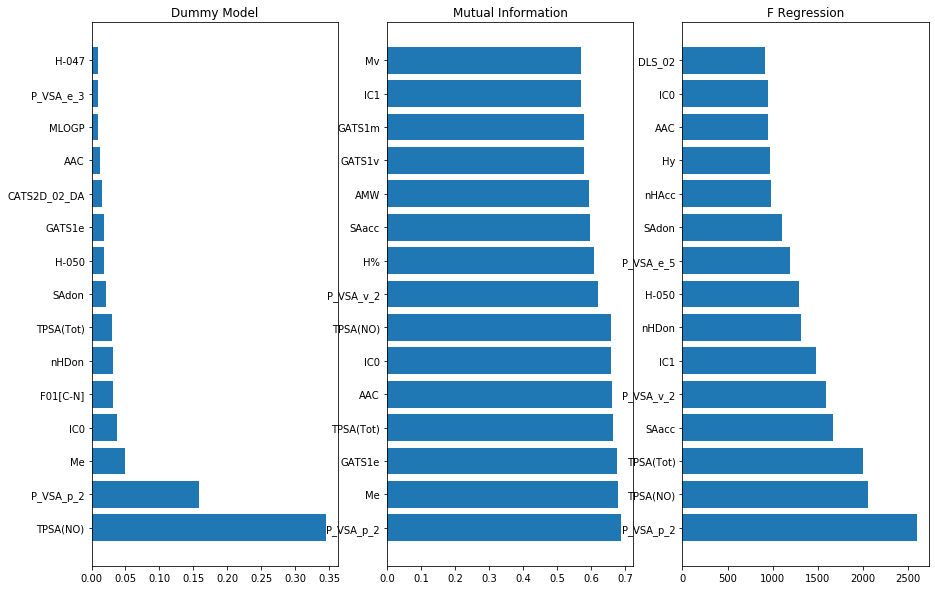

In [8]:
fig, imp_plot = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
imp_plot[0].barh(importances.nlargest(15).index, importances.nlargest(15))
imp_plot[0].set_title('Dummy Model')
imp_plot[1].barh(scores_mutual.nlargest(15).index, scores_mutual.nlargest(15))
imp_plot[1].set_title('Mutual Information')
imp_plot[2].barh(scores_f.nlargest(15).index, scores_f.nlargest(15))
imp_plot[2].set_title('F Regression')
plt.show()

## GradientBoosting
Using grid search to find ideal hyperparameters

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)

#model_gbr = ensemble.GradientBoostingRegressor()

#param_grid = {
#    'n_estimators': [500, 1000, 2000],
#    'max_depth': [2, 4, 6],
#    'min_samples_leaf': [3, 5, 9, 17],
#    'learning_rate': [0.1, 0.05, 0.02],
#    'max_features': [1.0, 0.3, 0.1],
#    'loss': ['ls', 'lad', 'huber']
#}

#grid_search_gbr = GridSearchCV(model_gbr, param_grid, n_jobs=2)

#grid_search_gbr.fit(X_train, y_train)

#gbr_hyperparams = grid_search_gbr.best_params_

#print(gbr_hyperparams)

Grid search completed 20:16 27/12/19 - results: <br>
`{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 1000}`
### Model-chosen features

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
grad_boost = ensemble.GradientBoostingRegressor(learning_rate = 0.02,
                                                loss = 'lad',
                                                max_depth = 6,
                                                max_features = 0.3,
                                                min_samples_leaf = 3,
                                                n_estimators = 1000)
grad_boost.fit(X_train, y_train)

exp_vs_calc_gbr = produce_exp_vs_pred_df(top_15_features_model, grad_boost, "GradBoost, model-chosen features")

Training Score:	 0.9529858301548719
Testing Score:	 0.7931941829423237


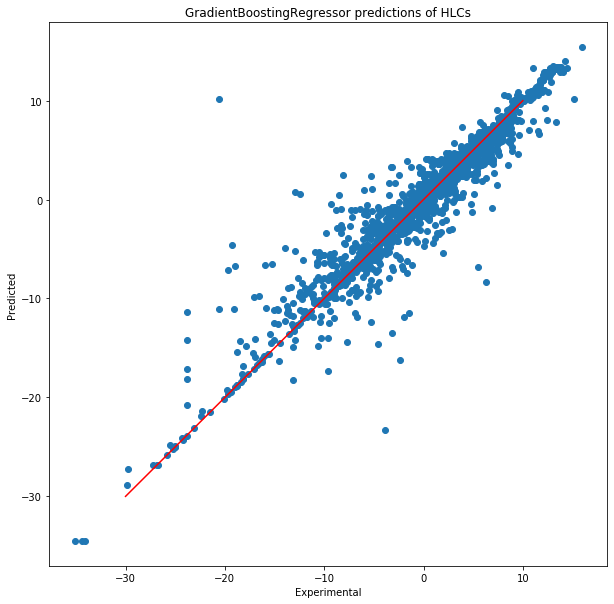

In [11]:
prediction_plot_scores(grad_boost, exp_vs_calc_gbr)

### Kbest + f_reg features

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_kbest], y, test_size=0.3)
grad_boost = ensemble.GradientBoostingRegressor(learning_rate = 0.02,
                                                loss = 'lad',
                                                max_depth = 6,
                                                max_features = 0.3,
                                                min_samples_leaf = 3,
                                                n_estimators = 1000)
grad_boost.fit(X_train, y_train)

exp_vs_calc_gbr_kbest_freg = produce_exp_vs_pred_df(top_15_features_kbest, grad_boost, "GradBoost, f_reg features")

Training Score:	 0.92622953353834
Testing Score:	 0.8292820287616747


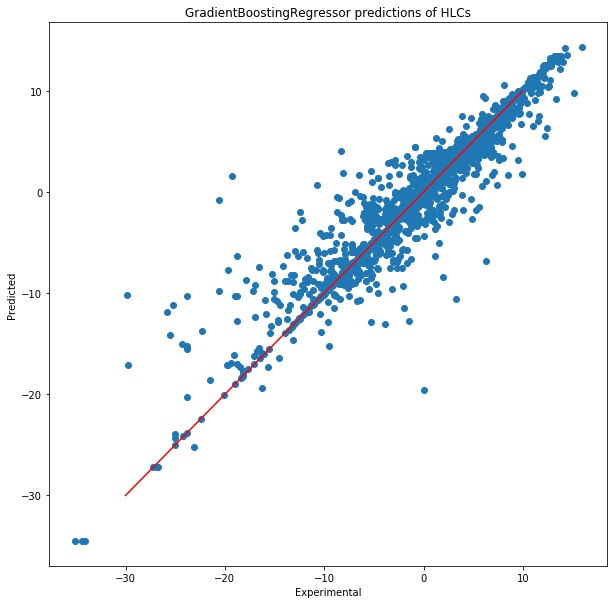

In [13]:
prediction_plot_scores(grad_boost, exp_vs_calc_gbr_kbest_freg)

### K-best using mutual-info scoring function

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_mutual_info], y, test_size=0.3)
grad_boost_mu = ensemble.GradientBoostingRegressor(learning_rate = 0.02,
                                                loss = 'lad',
                                                max_depth = 6,
                                                max_features = 0.3,
                                                min_samples_leaf = 3,
                                                n_estimators = 1000)
grad_boost_mu.fit(X_train, y_train)

exp_vs_calc_gbr_mu = produce_exp_vs_pred_df(top_15_features_mutual_info, grad_boost_mu, "GradBoost, Mutual Info")

Training Score:	 0.9259616126581424
Testing Score:	 0.8424645626859661


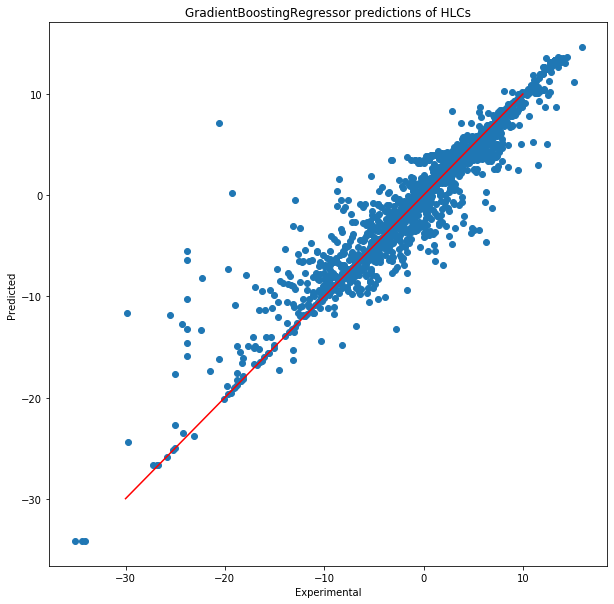

In [15]:
prediction_plot_scores(grad_boost_mu, exp_vs_calc_gbr_mu)

### Comments on feature selection for gradient boosting
- 'Dummy' model for feature selection gave best test score - 0.84 compared to 0.81 for the SelectKBest methods. Perhaps a grid search should be used for each set of features?

## Decision Tree

In [16]:
dtr = tree.DecisionTreeRegressor(criterion = 'mse',
                                 max_depth =10, 
                                 max_features = 15, 
                                 max_leaf_nodes = 29, 
                                 min_impurity_decrease = 0.0, 
                                 min_impurity_split = None, 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2, 
                                 min_weight_fraction_leaf = 0.0, 
                                 presort = False, 
                                 random_state = None, 
                                 splitter = 'best')
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
dtr.fit(X_train, y_train)

exp_vs_calc_dtr = produce_exp_vs_pred_df(top_15_features_model, dtr, "Decision Tree")

Training Score:	 0.8591114694623222
Testing Score:	 0.7849985927893628


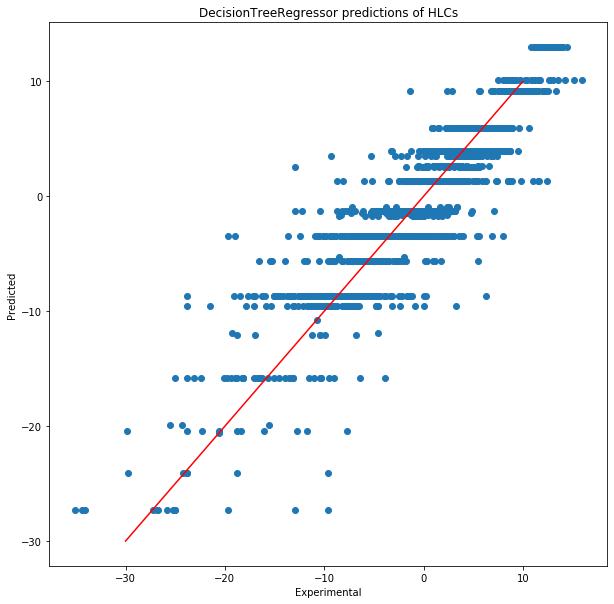

In [17]:
prediction_plot_scores(dtr, exp_vs_calc_dtr)

## AdaBoost Regressor

In [18]:
ada = ensemble.AdaBoostRegressor(base_estimator = None, 
                                 learning_rate = 0.8, 
                                 loss = 'exponential', 
                                 n_estimators = 50, 
                                 random_state = None)
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
ada.fit(X_train, y_train)

exp_vs_calc_ada = produce_exp_vs_pred_df(top_15_features_model, ada, "AdaBoost")

Training Score:	 0.7590145342824859
Testing Score:	 0.7269076329436315


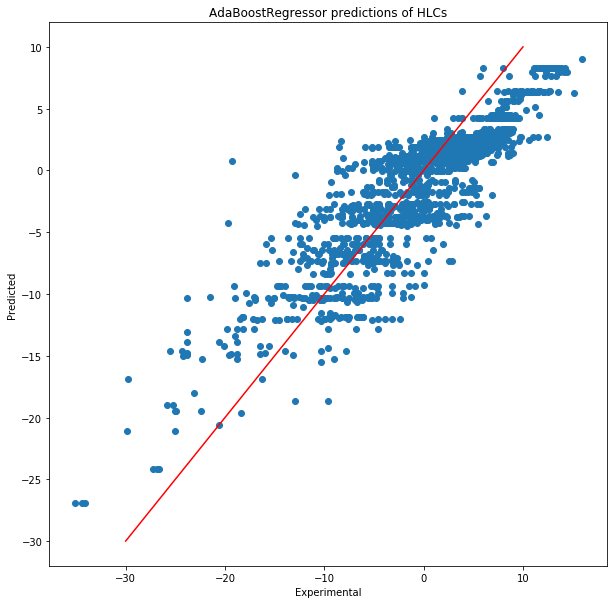

In [19]:
prediction_plot_scores(ada, exp_vs_calc_ada)

## LASSO

In [20]:
lasso = linear_model.Lasso(alpha=0.1, max_iter=10000)
X_train, X_test, y_train, y_test = train_test_split(X[top_15_features_model], y, test_size=0.3)
lasso.fit(X_train, y_train)

exp_vs_calc_lasso = produce_exp_vs_pred_df(top_15_features_model, lasso, "LASSO")

Training Score:	 0.7505045819059173
Testing Score:	 0.7822239352527062


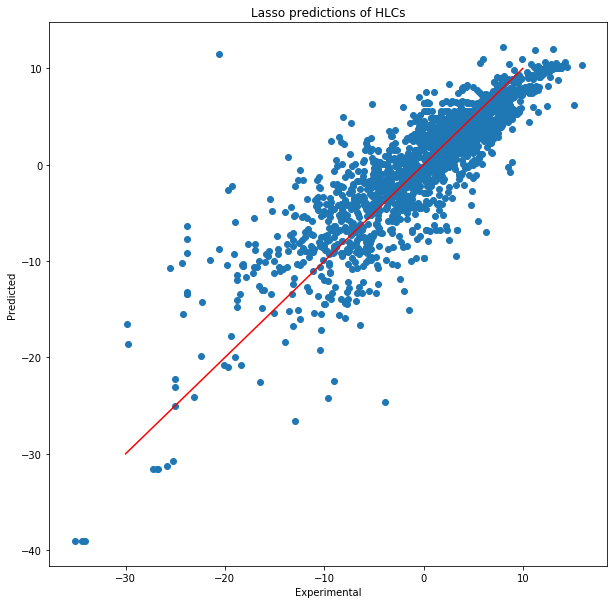

In [21]:
prediction_plot_scores(lasso, exp_vs_calc_lasso)

## Tensorflow

## PCA

## Scores

In [22]:
display("Training Scores", train_scores, "Testing Scores", test_scores)

'Training Scores'

{'GradBoost, model-chosen features': 0.9529858301548719,
 'GradBoost, f_reg features': 0.92622953353834,
 'GradBoost, Mutual Info': 0.9259616126581424,
 'Decision Tree': 0.8591114694623222,
 'AdaBoost': 0.7590145342824859,
 'LASSO': 0.7505045819059173}

'Testing Scores'

{'GradBoost, model-chosen features': 0.7931941829423237,
 'GradBoost, f_reg features': 0.8292820287616747,
 'GradBoost, Mutual Info': 0.8424645626859661,
 'Decision Tree': 0.7849985927893628,
 'AdaBoost': 0.7269076329436315,
 'LASSO': 0.7822239352527062}

In [23]:
exp_vs_calc_df_list = []
for var in dir():
    if isinstance(eval(var), pd.core.frame.DataFrame):
        if var[0:3] == 'exp':
            exp_vs_calc_df_list.append(var)
            
@widgets.interact()

def show_pred_vs_actual(pred_df = exp_vs_calc_df_list):
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(eval(pred_df)['Experimental'], eval(pred_df)['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    #abels = ['{}'.format(i) for i in species_names]
    #ooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    #pld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

interactive(children=(Dropdown(description='pred_df', options=('exp_vs_calc_ada', 'exp_vs_calc_dtr', 'exp_vs_c…